# Evaluation
## Imports

In [4]:
import ast
import os
os.environ['MODIN_ENGINE'] = 'dask'
import modin.pandas as pd
from collections import Counter

from nltk.corpus import stopwords
stopwords = stopwords.words('german')
import string
from HanTa import HanoverTagger as ht
tagger = ht.HanoverTagger('./morphmodel_ger.pgz')
import re

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import preprocessing
from scipy.stats import ttest_rel
from  scipy  import  stats

## Load data

In [2]:
chunksize= 10 ** 6
chunks = pd.read_csv('../data/btw17_rawdata_gender.csv', chunksize=chunksize)
btw17_rawdata_df = pd.concat(chunks)

In [ ]:
btw17_rawdata_df.head(3)

## Preprocessing
*Preprocessing Pipeline from preprocessing.ipynb is used except for duplicate removal*

In [ ]:
with open('../data/all_names_to_delete.txt', 'r', encoding='utf-8') as f:
    names = [term[:-1] for term in f.readlines()]
word_pattern = re.compile('\w+')
with open('.../data/wordlist-german.txt', 'r', encoding='utf-8') as f:
    german_terms = [term[:-1].lower() for term in f.readlines()]

In [ ]:
def delete_names(matchobj)->str:
    word = matchobj.group(0)
    if word in names:
        return ""
    else:
        return word

In [ ]:
def preprocess_keep_duplicates(suggestions:list)->list:
    suggestions = tuple(map(lambda x: x.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation))), suggestions))
    suggestions = [word_pattern.sub(delete_names, term.lower()) for term in suggestions]
    suggestions = [suggestion for suggestion in suggestions if len(suggestion.split()) == 1]
    suggestions = tuple(map(lambda x: re.sub('[0-9]*', '', x), suggestions))
    suggestions = [x.lower() for x in suggestions]
    suggestions = [x for x in suggestions if not 'http' in x]
    suggestions = [x for x in suggestions if not x in stopwords]
    suggestions = [tagger.analyze(tagger.analyze(suggestion)[0])[0].lower()
                   for suggestion in suggestions
                   if tagger.analyze(tagger.analyze(suggestion)[0])[1] in ['NN']]
    suggestions = [re.sub('(^..?\s|\s..?\s|\s..?$|^..?$)', '', string) for string in suggestions]
    suggestions = [x.strip() for x in suggestions]
    suggestions = list(filter(None, suggestions))
    suggestions = [term for term in suggestions if term in german_terms]
    return (suggestions)

## Group by gender
*Create one DataFrame for terms suggested for male politicians and one for terms suggested for female politicians*
#### *female*

In [ ]:
female_suggestions = btw17_rawdata_df.groupby('gender').get_group('female')

### *male*

In [ ]:
male_suggestions = btw17_rawdata_df.groupby('gender').get_group('male')

## Turn DataFrames into flat lists, preprocess the terms of each list and keep the duplicates

\**Preprocessing is performed on slices in a loop and results are saved to file as a workaround for memory errors*

### *female*

In [ ]:
for i in range(0,len(female_suggestions)+1,int(len(female_suggestions)/10)):
    j = i+int(len(female_suggestions)/10)
    female_suggestions_prep = [term for row in female_suggestions.suggestions[i:j].to_list() for term in ast.literal_eval(row)]
    with open('../data/female_suggestions_prep.txt','a',encoding='utf-8') as file:
        for item in female_suggestions_prep:
            file.write(item+'\n')

### *male*

In [ ]:
for i in range(0,len(male_suggestions)+1,int(len(male_suggestions)/10)):
    j = i+int(len(male_suggestions)/10)
    male_suggestions_prep = [term for row in male_suggestions.suggestions.iloc[i:j].to_list() for term in ast.literal_eval(row)]
    with open('../data/male_suggestions_prep.txt','a',encoding='utf-8') as file:
        for item in male_suggestions_prep:
            file.write(item+'\n')

## Count occurrences of words per cluster and gender

### Load Clusters

In [ ]:
cluster_df = pd.read_csv('../data/manual_clustering.csv')

*Remove the "geographical" and "other" clusters since they're not comparable*

In [ ]:
cluster_df = cluster_df[1:-1]

In [ ]:
clusters = [ast.literal_eval(cluster) for cluster in cluster_df.cluster_terms.to_list()]

## Load suggestion terms and count occurences per cluster
### *female*

In [ ]:
with open('../data/female_suggestions_prep.txt', 'r',encoding = 'utf-8') as file:
    female_suggestions = [term[:-1] for term in file.readlines() if term != '']

In [ ]:
female_counts = Counter(female_suggestions)

In [ ]:
for index,cluster in enumerate(clusters):
    count = 0
    for term in cluster:
        count += int(female_counts[term])
    cluster_df.at[index,'female_count'] = count

In [ ]:
cluster_df[['cluster_label','cluster_terms','female_count']].to_csv('../data/cluster_count_female.csv')

### *male*

In [ ]:
with open('../data/male_suggestions_prep.txt', 'r',encoding = 'utf-8') as file:
    content = file.read()
    male_suggestions = content.split('\n')#[term[:-1] for term in file.readlines() if term != '']

In [ ]:
male_counts = Counter(male_suggestions)

In [ ]:
for cluster in clusters:
    count=0
    for term in cluster:
        print(term)
        count+=int(male_counts[term])
    with open('../male_cluster_counts.csv','a') as file:
        file.write(str(count)+'\n')

## Genderize API Evaluation
### Load Gender data

In [19]:
btw17_name_gender_df = pd.read_csv('../data/btw17_name_gender_df.csv')
btw17_name_gender_df.head(5)

,Unnamed: 0,f_name,gender,gender_probability
0,0,Gunnar,male,0.99
1,1,Ates,male,0.90
2,2,bundeskanzlerin,male,1.00
3,3,Michael,male,0.99
4,4,Maurice,male,0.98


### Load and prepare testset

In [20]:
politician_df = pd.read_csv('../data/politiker.csv')
politician_df.head(5)


,Unnamed: 0,Name,Born,Party,Bundesland,Gender,Age
0,0,Wolfgang Stefinger,1985,CSU,Bayern,male,35
1,1,Kai Whittaker,1985,CDU,Baden-Württemberg,male,35
2,2,Katrin Albsteiger,1983,CSU,Bayern,female,37
3,3,Susanna Karawanskij,1980,DIE LINKE,Sachsen,female,40
4,4,Florian Oßner,1980,CSU,Bayern,male,40


In [21]:
politician_df['f_name'] = politician_df['Name'].apply(lambda x: x.split(' ')[0])
politician_df = politician_df[['Gender','f_name']]
politician_df = politician_df.rename(columns={'Gender': 'gender_test'})
politician_df = politician_df[['f_name','gender_test']]
politician_df = politician_df.drop_duplicates()
politician_df.head(5)

,f_name,gender_test
0,Wolfgang,male
1,Kai,male
2,Katrin,female
3,Susanna,female
4,Florian,male


In [22]:
btw17_name_gender_df = btw17_name_gender_df[['f_name','gender']]
btw17_name_gender_df.head(5)

,f_name,gender
0,Gunnar,male
1,Ates,male
2,bundeskanzlerin,male
3,Michael,male
4,Maurice,male


In [23]:
politician_df = politician_df.dropna()
btw17_name_gender_df = btw17_name_gender_df.dropna()

In [24]:
print(politician_df.shape)
btw17_name_gender_df.shape

(505, 2)


(824, 2)

In [25]:
politician_df = politician_df.reset_index(drop=True)
btw17_name_gender_df = btw17_name_gender_df.reset_index(drop=True)

In [26]:
merged_gender_df = btw17_name_gender_df.merge(politician_df, on='f_name').astype(str)
merged_gender_df.columns = ['f_name','gender_pred','gender_true']
merged_gender_df.head(5)

,f_name,gender_pred,gender_true
0,Ates,male,male
1,Michael,male,male
2,Florian,male,male
3,Renata,female,female
4,David,male,male


## Create a confusion matrix

In [27]:
gender_pred = merged_gender_df['gender_pred']
gender_true = merged_gender_df['gender_true']

confusion_df = pd.crosstab(gender_true, gender_pred, margins=True,rownames=['gender_true'], colnames=['gender_pred'])
print(confusion_df)

gender_pred  female  male  All
gender_true                   
female          196    16  212
male              9   255  264
All             205   271  476


<Figure size 432x288 with 0 Axes>

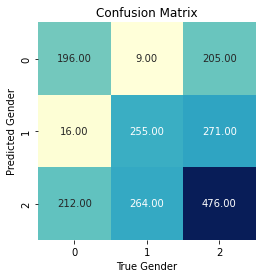

In [28]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = sn.heatmap(confusion_df.T, annot=True, fmt='.2f', cmap="YlGnBu", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('True Gender')
plt.ylabel('Predicted Gender')
plt.savefig("../data/confusion_matrix.png", dpi=300)
plt.show()

## Gender Cluster Evaluation

In [32]:
cluster_count_df = pd.read_csv('../data/cluster_count_female.csv')
cluster_count_df['male_count']  = pd.read_csv('../male_cluster_counts.csv')
cluster_count_df.head(3)

,cluster_label,cluster_terms,female_count,male_count
0,unternehmen_marken,"['bauhaus', 'prosieben', 'sparkasse', 'vorwerk...",153774.0,1160934
1,sport_hobbies,"['angeln', 'poker', 'liga', 'club', 'league', ...",387765.0,1273553
2,nachrichten,"['kicker', 'stuttgarter', 'tagesspiegel', 'ver...",164599.0,422864


In [33]:
cluster_count_df = cluster_count_df[['cluster_label','female_count', 'male_count']]
cluster_count_df.head(10)

,cluster_label,female_count,male_count
0,unternehmen_marken,153774.0,1160934
1,sport_hobbies,387765.0,1273553
2,nachrichten,164599.0,422864
3,militaer_polizei,46554.0,256233
4,technologie_medien,5164307.0,10949863
5,kunst_kultur,862283.0,2917762
6,bildung,94751.0,639067
7,wissenschaft_forschung,27145.0,216907
8,mode_aussehen,41138.0,24418
9,privatleben,2323851.0,6582455


In [34]:
x = cluster_count_df[['female_count', 'male_count']].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
cluster_count_df = pd.concat([cluster_count_df,pd.DataFrame(x_scaled)], axis=1)
cluster_count_df.columns = ['cluster_label','female_count','male_count','female_norm','male_norm']
cluster_count_df.head(10)


,cluster_label,female_count,male_count,female_norm,male_norm
0,unternehmen_marken,153774.0,1160934,0.029776,0.104718
1,sport_hobbies,387765.0,1273553,0.075085,0.115018
2,nachrichten,164599.0,422864,0.031872,0.037215
3,militaer_polizei,46554.0,256233,0.009014,0.021975
4,technologie_medien,5164307.0,10949863,1.000000,1.000000
5,kunst_kultur,862283.0,2917762,0.166969,0.265395
6,bildung,94751.0,639067,0.018347,0.056989
7,wissenschaft_forschung,27145.0,216907,0.005256,0.018379
8,mode_aussehen,41138.0,24418,0.007965,0.000774
9,privatleben,2323851.0,6582455,0.449983,0.600563


In [35]:
total_female_norm = pd.Series(cluster_count_df['female_norm'], dtype='float').sum()
total_male_norm = pd.Series(cluster_count_df['male_norm'], dtype='float').sum()

cluster_count_df['female_perc'] = cluster_count_df.female_norm.apply(lambda x: float(x) / total_female_norm )
cluster_count_df['male_perc'] = cluster_count_df.male_norm.apply(lambda x: float(x) / total_male_norm )
cluster_count_df.head(5)

,cluster_label,female_count,male_count,female_norm,male_norm,female_perc,male_perc
0,unternehmen_marken,153774.0,1160934,0.029776,0.104718,0.014066,0.039817
1,sport_hobbies,387765.0,1273553,0.075085,0.115018,0.035470,0.043734
2,nachrichten,164599.0,422864,0.031872,0.037215,0.015056,0.014150
3,militaer_polizei,46554.0,256233,0.009014,0.021975,0.004258,0.008356
4,technologie_medien,5164307.0,10949863,1.000000,1.000000,0.472398,0.380235


## Plot distribution

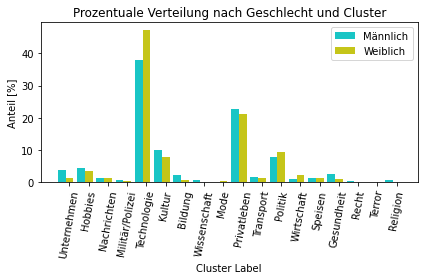

In [36]:
# data to plot
n_cluster = 18
male_perc = cluster_count_df['male_perc']*100
female_perc = cluster_count_df['female_perc']*100

# create plot
fig, ax = plt.subplots()
index = np.arange(n_cluster)
bar_width = 0.40
opacity = 0.9

rects1 = plt.bar(index, male_perc, bar_width,
alpha=opacity,
color='c',
label='Männlich')

rects2 = plt.bar(index + bar_width, female_perc, bar_width,
alpha=opacity,
color='y',
label='Weiblich')

plt.xlabel('Cluster Label')
plt.ylabel('Anteil [%]')
plt.title('Prozentuale Verteilung nach Geschlecht und Cluster')
plt.xticks(index + bar_width ,['Unternehmen',
                               'Hobbies',
                               'Nachrichten',
                               'Militär/Polizei',
                               'Technologie',
                               'Kultur',
                               'Bildung',
                               'Wissenschaft',
                               'Mode',
                               'Privatleben',
                               'Transport',
                               'Politik',
                               'Wirtschaft',
                               'Speisen',
                               'Gesundheit',
                               'Recht',
                               'Terror',
                               'Religion'], rotation = 80)
plt.legend()

plt.tight_layout()
plt.savefig('../data/distribution_gender_cluster.png', dpi=300)
plt.show()

## Independent T-Test

In [37]:
female_cluster_norm = cluster_count_df['female_norm'].apply(lambda x: float(x))
male_cluster_norm = cluster_count_df['male_norm'].apply(lambda x: float(x))

In [38]:
stats.ttest_ind(male_cluster_norm,female_cluster_norm)




Ttest_indResult(statistic=0.33932825761346574, pvalue=0.7364495584833557)